## Import statements
Loading all the necessary libraries needed

In [1]:
import logging
import math
import os
import sys

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from ipywidgets import IntProgress
from keras.layers import LSTM, Conv1D, Dense, Dropout,BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

"Need for predicting a music genre from a custom audio file"
import IPython.display as ipd
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from datetime import datetime 

#### Setting log level to error and default figure size for graphs

In [2]:
plt.rcParams["figure.figsize"] = (13, 5)
# set logging level
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Loading data and meta data from disk

In [3]:
metadata_path = "C:\\Users\\A0826873\\Bits\\DL\\Assignment-2\\data\\fma_metadata\\"
audio_dataset_path = "C:\\Users\\A0826873\\Bits\\DL\\Assignment-2\\data\\fma_small\\"

tracks = pd.read_csv(metadata_path + "/tracks.csv", header=[0, 1], index_col=0)
small_tracks = tracks[tracks["set", "subset"] == "small"]

#### Exploratory data analysis 

In [4]:
print(small_tracks.shape)
print(small_tracks.size)
print(small_tracks.index)
print(type(small_tracks))
print(small_tracks["album", "id"])
print(small_tracks["track", "genre_top"].value_counts())

(8000, 52)
416000
Int64Index([     2,      5,     10,    140,    141,    148,    182,    190,
               193,    194,
            ...
            153956, 154303, 154305, 154306, 154307, 154308, 154309, 154413,
            154414, 155066],
           dtype='int64', name='track_id', length=8000)
<class 'pandas.core.frame.DataFrame'>
track_id
2             1
5             1
10            6
140          61
141          60
          ...  
154308    22780
154309    22780
154413    22789
154414    22789
155066    22899
Name: (album, id), Length: 8000, dtype: int64
Hip-Hop          1000
Pop              1000
Folk             1000
Experimental     1000
Rock             1000
International    1000
Electronic       1000
Instrumental     1000
Name: (track, genre_top), dtype: int64


In [5]:
print(small_tracks["set", "split"].value_counts())

training      6400
validation     800
test           800
Name: (set, split), dtype: int64


In [6]:
genre_list = list(small_tracks["track", "genre_top"].unique())
print(genre_list)

['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']


In [7]:
Y_genre_strings = small_tracks["track", "genre_top"]
y_one_hot = np.zeros((Y_genre_strings.shape[0], len(genre_list)))
for i, genre_string in enumerate(Y_genre_strings):
    index = genre_list.index(genre_string)
    y_one_hot[i, index] = 1
print(y_one_hot.shape)

(8000, 8)


#### Printing samples

Trackid is 11783
The Genre it belongs is Hip-Hop
C:\Users\A0826873\Bits\DL\Assignment-2\data\fma_small\011\011783.mp3
STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


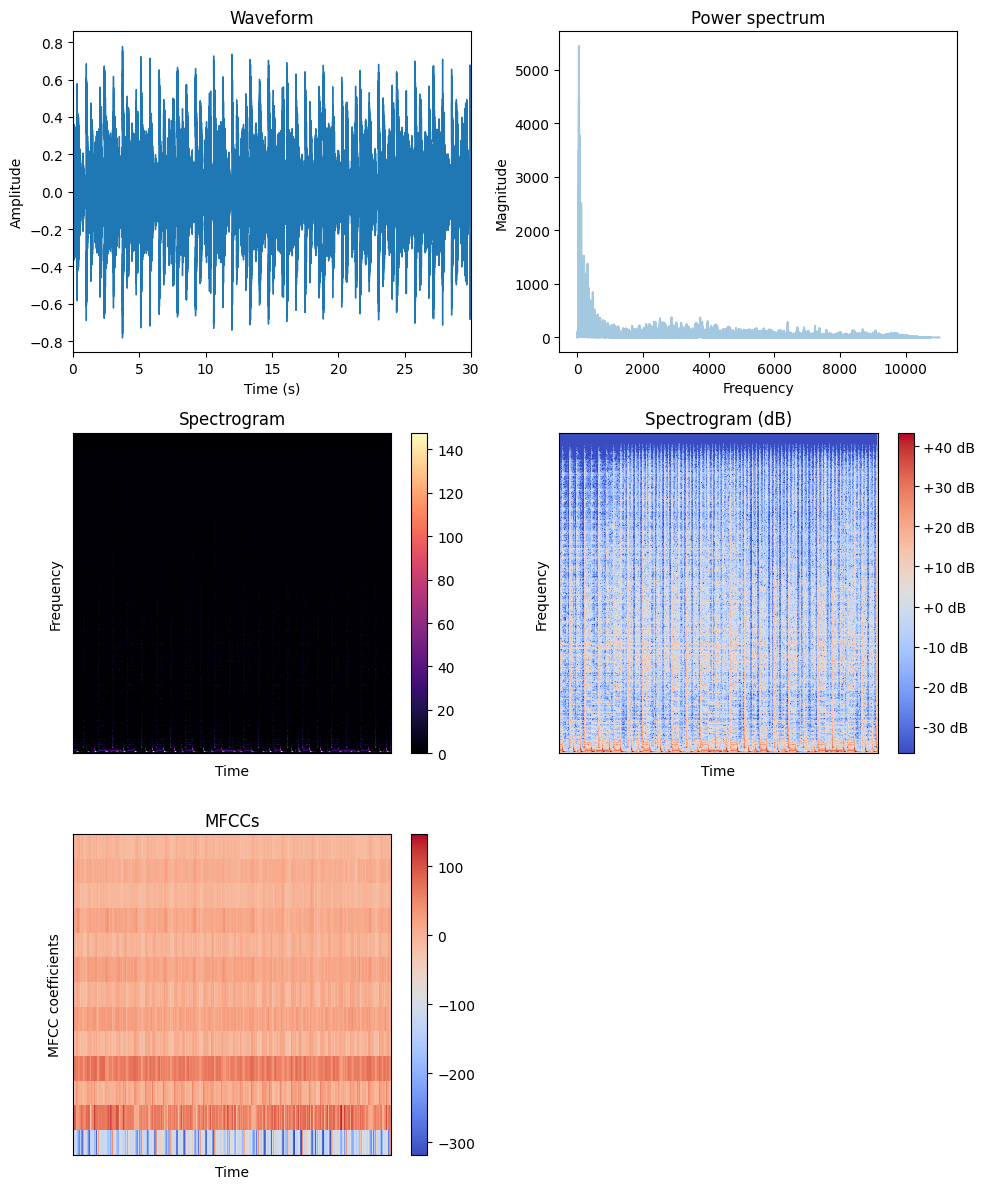

Trackid is 108022
The Genre it belongs is Instrumental
C:\Users\A0826873\Bits\DL\Assignment-2\data\fma_small\108\108022.mp3
STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


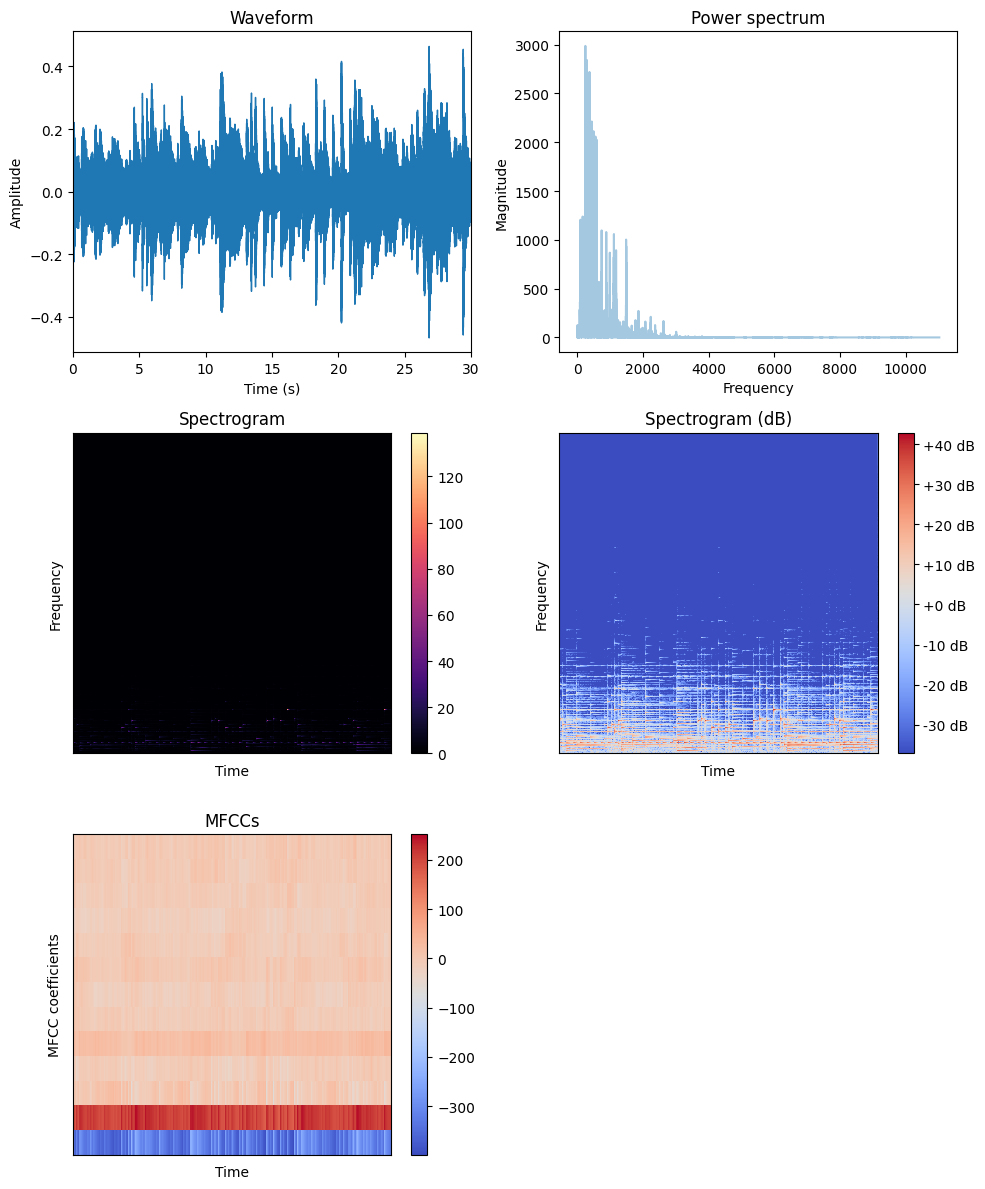

In [8]:
class GraphGenerator:
    def generategraph(self, file, FIG_SIZE=(10, 12)):
        # load audio file with Librosa
        signal, sample_rate = librosa.load(file, sr=22050)
        # fig, ax = plt.subplots(3,2)

        # WAVEFORM
        # display waveform
        fig = plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 1)
        librosa.display.waveplot(signal, sr=sample_rate)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title("Waveform")

        # FFT -> power spectrum
        # perform Fourier transform
        fft = np.fft.fft(signal)

        # calculate abs values on complex numbers to get magnitude
        spectrum = np.abs(fft)

        # create frequency variable
        f = np.linspace(0, sample_rate, len(spectrum))

        # take half of the spectrum and frequency
        left_spectrum = spectrum[: int(len(spectrum) / 2)]
        left_f = f[: int(len(spectrum) / 2)]

        # plot spectrum
        # plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 2)
        plt.plot(left_f, left_spectrum, alpha=0.4)
        plt.xlabel("Frequency")
        plt.ylabel("Magnitude")
        plt.title("Power spectrum")

        # STFT -> spectrogram
        hop_length = 512  # in num. of samples
        n_fft = 2048  # window in num. of samples

        # calculate duration hop length and window in seconds
        hop_length_duration = float(hop_length) / sample_rate
        n_fft_duration = float(n_fft) / sample_rate

        print("STFT hop length duration is: {}s".format(hop_length_duration))
        print("STFT window duration is: {}s".format(n_fft_duration))

        # perform stft
        stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

        # calculate abs values on complex numbers to get magnitude
        spectrogram = np.abs(stft)

        # display spectrogram
        # plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 3)
        librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.title("Spectrogram")

        # apply logarithm to cast amplitude to Decibels
        log_spectrogram = librosa.amplitude_to_db(spectrogram)

        # plt.figure(figsize=FIG_SIZE)
        plt.subplot(3, 2, 4)
        librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format="%+2.0f dB")
        plt.title("Spectrogram (dB)")

        # MFCCs
        # extract 13 MFCCs
        MFCCs = librosa.feature.mfcc(
            signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13
        )

        # display MFCCs
        plt.subplot(3, 2, 5)
        librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("MFCC coefficients")
        plt.colorbar()
        plt.title("MFCCs")
        fig.tight_layout()
        # show plots
        plt.show()


import random

trackids = small_tracks["track"].index
random.seed(10)
graph_generator = GraphGenerator()
for i in range(0, 2):
    n = random.Random().randint(0, len(trackids))
    track_id = trackids[n]
    tid_str = "{:06d}".format(track_id)
    file = os.path.join(
        audio_dataset_path,
        tid_str[:3],
        tid_str + ".mp3",
    )
    ipd.Audio(file)
    track_genre = small_tracks.loc[track_id]["track", "genre_top"]
    print("Trackid is {}".format(track_id))
    print("The Genre it belongs is {}".format(track_genre))
    print(file)

    graph_generator.generategraph(file)

#### Making data frame for processing & Pre -processing

In [9]:
trackids = small_tracks["track"].index
track_info = pd.DataFrame()
track_info["track_id"] = trackids

trackids = trackids.map(lambda track_id: "{:06d}".format(track_id))

track_info["file_path"] = trackids.map(
    lambda file: os.path.join(audio_dataset_path, file[:3], file + ".mp3")
)
# print(track_info.head())
dt = pd.DataFrame(small_tracks["track", "genre_top"])
# since it is multicolumn so resetting index
dt = dt.reset_index("track_id", col_level=1, col_fill="track")
# we just want a single index data frame to join
dt = dt["track"]
# Joining with track info to get required data set
track_info = track_info.join(dt.set_index("track_id"), on="track_id")

In [10]:
print(track_info.head())
print(track_info.iloc[0, :][1])
ipd.Audio(track_info.iloc[0, :][1])

   track_id                                          file_path genre_top
0         2  C:\Users\A0826873\Bits\DL\Assignment-2\data\fm...   Hip-Hop
1         5  C:\Users\A0826873\Bits\DL\Assignment-2\data\fm...   Hip-Hop
2        10  C:\Users\A0826873\Bits\DL\Assignment-2\data\fm...       Pop
3       140  C:\Users\A0826873\Bits\DL\Assignment-2\data\fm...      Folk
4       141  C:\Users\A0826873\Bits\DL\Assignment-2\data\fm...      Folk
C:\Users\A0826873\Bits\DL\Assignment-2\data\fma_small\000\000002.mp3


#### Splitting Data set into Train, test and validation

In [11]:
class MusicFeatureExtractor:
    "Music audio features for genre classification"
    hop_length = None
    genre_list = None

    train_X_preprocessed_data = "./data/data_train_input.npy"
    train_Y_preprocessed_data = "./data/data_train_target.npy"
    dev_X_preprocessed_data = "./data/data_validation_input.npy"
    dev_Y_preprocessed_data = "./data/data_validation_target.npy"
    test_X_preprocessed_data = "./data/data_test_input.npy"
    test_Y_preprocessed_data = "./data/data_test_target.npy"

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self, dataframe, genre_list, compute_time=False):
        self.hop_length = 512
        self.genre_list = genre_list
        self.timeseries_length_list = []
        self.train_dataset, self.validate_dataset, self.test_dataset = self.split_data(
            dataframe
        )

        self.data_given = dataframe
        if compute_time == True:
            # compute minimum timeseries length, slow to compute, caching pre-computed value of 1290
            self.precompute_min_timeseries_len()
            print(
                "min(self.timeseries_length_list) =="
                + str(min(self.timeseries_length_list))
            )
            self.timeseries_length = min(self.timeseries_length_list)
        else:
            self.timeseries_length = 128  # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050
        #  equals 128 overlapped windows that cover approx ~3.065 seconds of audio

    def split_data(self, dataframe):
        if type(dataframe) != type(pd.DataFrame) and dataframe.size == 0:
            return
        total_no_of_tracks = dataframe.size
        print("Total sample size given is {}and shape {}.".format(dataframe.size, dataframe.shape))
        train, validate, test = np.split(
            track_info, [int(0.8 * len(dataframe)), int(0.9 * len(dataframe))]
        )
        print("\nTraining sample size is {} and shape {}.".format(train.size, train.shape))
        print("Validation sample size is {} and shape {}.".format(validate.size, validate.shape))
        print("Testing sample size is {} and shape {}.".format(test.size, test.shape))
        print("\nTraining sample percentage is {}%.".format(train.size * 100 / total_no_of_tracks))
        print("Validation sample percentage is {}%. ".format(validate.size * 100 / total_no_of_tracks))
        print("Testing sample percentage is {}%".format(test.size * 100 / total_no_of_tracks))
        # train.head()
        return train, validate, test

    def load_preprocess_data(self):
        print("[DEBUG] total number of files: " + str(len(self.timeseries_length_list)))
        print("\nExtracting audio features of training data")
        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.train_dataset)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)
        print("\nExtracting audio features of validation data")
        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.validate_dataset)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)
        print("\nExtracting audio features of testing data")
        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.test_dataset)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):
        self.train_X = np.load(self.train_X_preprocessed_data)
        self.train_Y = np.load(self.train_Y_preprocessed_data)

        self.dev_X = np.load(self.dev_X_preprocessed_data)
        self.dev_Y = np.load(self.dev_Y_preprocessed_data)

        self.test_X = np.load(self.test_X_preprocessed_data)
        self.test_Y = np.load(self.test_Y_preprocessed_data)

    def precompute_min_timeseries_len(self):
        max_count = len(self.data_given["file_path"])
        f = IntProgress(
            min=0,
            max=max_count,
            description="Computing Progress:",
            bar_style="info",
            orientation="horizontal",
        )  # instantiate the bar
        ipd.display(f)  # display the bar
        for file in self.data_given["file_path"]:
            # print("Loading " + str(file))
            try:
                y, sr = librosa.load(file)
                f.value += 1
                self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))
            except:
                e = sys.exc_info()[0]
                print("Error while loading file :{}".format(file))

    def extract_audio_features(self, audio_data):
        max_count = audio_data.shape[0]
        progress = IntProgress(
            min=0,
            max=max_count,
            description="Progress:",
            bar_style="info",
            orientation="horizontal",
        )  # instantiate the bar
        ipd.display(progress)  # display the bar
        data = np.zeros(
            (audio_data.shape[0], self.timeseries_length, 33), dtype=np.float64
        )
        target = []
        count = None
        for i in range(0, audio_data.shape[0]):
            if count == None:
                count = i
            file_path = audio_data.iloc[i]["file_path"]
            genre = audio_data.iloc[i]["genre_top"]
            try:
                y, sr = librosa.load(file_path)
                mfcc = librosa.feature.mfcc(
                    y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
                )
                spectral_center = librosa.feature.spectral_centroid(
                    y=y, sr=sr, hop_length=self.hop_length
                )
                chroma = librosa.feature.chroma_stft(
                    y=y, sr=sr, hop_length=self.hop_length
                )
                spectral_contrast = librosa.feature.spectral_contrast(
                    y=y, sr=sr, hop_length=self.hop_length
                )
                target.append(genre)

                data[count, :, 0:13] = mfcc.T[0 : self.timeseries_length, :]
                data[count, :, 13:14] = spectral_center.T[0 : self.timeseries_length, :]
                data[count, :, 14:26] = chroma.T[0 : self.timeseries_length, :]
                data[count, :, 26:33] = spectral_contrast.T[0 : self.timeseries_length, :]
                print("Extracted features audio track %i of %i." % (i + 1,audio_data.shape[0]))
                count+=1
                progress.value += 1
            except:
                e = sys.exc_info()[0]
                print("Error while loading file: %s."%(file_path))
                # since there is error we need to remove corresponding entry in sample aslo
                data = np.delete(data,count,axis=0)
                #count = count-1                
                continue
        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".mp3"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [12]:
genre_features = MusicFeatureExtractor(track_info, genre_list)

Total sample size given is 24000and shape (8000, 3).

Training sample size is 19200 and shape (6400, 3).
Validation sample size is 2400 and shape (800, 3).
Testing sample size is 2400 and shape (800, 3).

Training sample percentage is 80.0%.
Validation sample percentage is 10.0%. 
Testing sample percentage is 10.0%


In [13]:
start_time = datetime.now()
if (
    os.path.isfile(genre_features.train_X_preprocessed_data)
    and os.path.isfile(genre_features.train_Y_preprocessed_data)
    and os.path.isfile(genre_features.dev_X_preprocessed_data)
    and os.path.isfile(genre_features.dev_Y_preprocessed_data)
    and os.path.isfile(genre_features.test_X_preprocessed_data)
    and os.path.isfile(genre_features.test_Y_preprocessed_data)
):
    print("Preprocessed files exist, deserializing npy files")
    genre_features.load_deserialize_data()
else:
    print("Preprocessing raw audio files")
    genre_features.load_preprocess_data()
end_time = datetime.now()
td = (end_time - start_time).total_seconds() * 10**3
print(f"Total time taken {td:.03f}ms.")
print("Training X shape: " + str(genre_features.train_X.shape))
print("Training Y shape: " + str(genre_features.train_Y.shape))
print("Dev X shape: " + str(genre_features.dev_X.shape))
print("Dev Y shape: " + str(genre_features.dev_Y.shape))
print("Test X shape: " + str(genre_features.test_X.shape))
print("Test Y shape: " + str(genre_features.test_Y.shape))

Preprocessed files exist, deserializing npy files
Total time taken 602.887ms.
Training X shape: (6395, 128, 33)
Training Y shape: (6395, 8)
Dev X shape: (799, 128, 33)
Dev Y shape: (799, 8)
Test X shape: (800, 128, 33)
Test Y shape: (800, 8)


def find_zero_vectors(array):
    list_zero_vectors = []
    shape = array.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            #print()
            if not np.any(array[i,j]):
                if not i in list_zero_vectors:
                    list_zero_vectors.append(i)
                    #print(i,j)
    return list_zero_vectors

#### Since there is mismatch that means few files failed while converting so we need to remove corresponding x entries

print(find_zero_vectors(genre_features.train_X))
print(find_zero_vectors(genre_features.dev_X))
print(find_zero_vectors(genre_features.test_X))

In [14]:
'''modified_train_X = []
modified_dev_X = []
xtrain_zero_index = find_zero_vectors(genre_features.train_X)
xdev_zero_index = find_zero_vectors(genre_features.dev_X)
for index in xtrain_zero_index:
    print(genre_features.train_X[index])
    print(f"Removing index {index}.")

modified_train_X =np.delete(genre_features.train_X,xtrain_zero_index,axis=0)
for index in xdev_zero_index :
    print(genre_features.dev_X[index])
    print(f"Removing index {index}.")
modified_dev_X=np.delete(genre_features.dev_X,xdev_zero_index,axis=0)'''


'modified_train_X = []\nmodified_dev_X = []\nxtrain_zero_index = find_zero_vectors(genre_features.train_X)\nxdev_zero_index = find_zero_vectors(genre_features.dev_X)\nfor index in xtrain_zero_index:\n    print(genre_features.train_X[index])\n    print(f"Removing index {index}.")\n\nmodified_train_X =np.delete(genre_features.train_X,xtrain_zero_index,axis=0)\nfor index in xdev_zero_index :\n    print(genre_features.dev_X[index])\n    print(f"Removing index {index}.")\nmodified_dev_X=np.delete(genre_features.dev_X,xdev_zero_index,axis=0)'

In [15]:
#print("\nTraining X shape: " + str(modified_train_X.shape))
print("Training X shape: " + str(genre_features.train_X.shape))
print("Training Y shape: " + str(genre_features.train_Y.shape))
#print("\nDev X shape: " + str(modified_dev_X.shape))
print("\nDev X shape: " + str(genre_features.dev_X.shape))
print("Dev Y shape: " + str(genre_features.dev_Y.shape))
print("\nTest X shape: " + str(genre_features.test_X.shape))
print("Test Y shape: " + str(genre_features.test_Y.shape))

Training X shape: (6395, 128, 33)
Training Y shape: (6395, 8)

Dev X shape: (799, 128, 33)
Dev Y shape: (799, 8)

Test X shape: (800, 128, 33)
Test Y shape: (800, 8)


In [16]:
# Keras optimizer defaults:
# Adam   : lr=0.001, beta_1=0.9,  beta_2=0.999, epsilon=1e-8, decay=0.
# RMSprop: lr=0.001, rho=0.9,                   epsilon=1e-8, decay=0.
# SGD    : lr=0.01,  momentum=0.,                             decay=0.

input_shape = (genre_features.train_X.shape[1], genre_features.train_X.shape[2])
print("Build LSTM CNN model ...")
model = Sequential()
model.add(Conv1D(128, 8, activation="relu", input_shape=input_shape))
model.add(BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,))
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(units=genre_features.train_Y.shape[1], activation="softmax"))
print("Compiling ...")

opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Build LSTM CNN model ...
Compiling ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 121, 128)          33920     
                                                                 
 batch_normalization (BatchN  (None, 121, 128)         512       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 121, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 121, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 121, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 121, 64)           0         
                 

In [17]:
from keras.callbacks import EarlyStopping
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
print("Training ...")
batch_size = 80  # num of training examples per minibatch
num_epochs = 200
model.fit(
    genre_features.train_X,
    genre_features.train_Y,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=[es]
)

Training ...
Epoch 1/200
80/80 [==============================] - 352s 4s/step - loss: 1.8879 - accuracy: 0.2771
Epoch 2/200
80/80 [==============================] - 324s 4s/step - loss: 1.7733 - accuracy: 0.3456
Epoch 3/200
80/80 [==============================] - 447s 6s/step - loss: 1.7281 - accuracy: 0.3692
Epoch 4/200
80/80 [==============================] - 338s 4s/step - loss: 1.7122 - accuracy: 0.3765
Epoch 5/200
80/80 [==============================] - 372s 5s/step - loss: 1.6716 - accuracy: 0.4030
Epoch 6/200
80/80 [==============================] - 333s 4s/step - loss: 1.6715 - accuracy: 0.4014
Epoch 7/200
80/80 [==============================] - 353s 4s/step - loss: 1.6308 - accuracy: 0.4188
Epoch 8/200
80/80 [==============================] - 331s 4s/step - loss: 1.6030 - accuracy: 0.4275
Epoch 9/200
80/80 [==============================] - 340s 4s/step - loss: 1.5880 - accuracy: 0.4355
Epoch 10/200
80/80 [==============================] - 354s 4s/step - loss: 1.5714 - acc

In [18]:
print("\nValidating ...")
score, accuracy = model.evaluate(
    genre_features.dev_X, genre_features.dev_Y, batch_size=batch_size, verbose=1
)
print("Dev loss:  ", score)
print("Dev accuracy:  ", accuracy)


Validating ...
10/10 [==============================] - 3s 135ms/step - loss: 3.9682 - accuracy: 0.3630
Dev loss:   3.9681596755981445
Dev accuracy:   0.36295369267463684


In [ ]:
#genre_features.train_Y.any(lambda y:y

In [19]:
print("\nTesting ...")
score, accuracy = model.evaluate(
    genre_features.test_X, genre_features.test_Y, batch_size=batch_size, verbose=1
)
print("Test loss:  ", score)
print("Test accuracy:  ", accuracy)


Testing ...
10/10 [==============================] - 1s 86ms/step - loss: 3.9730 - accuracy: 0.3988
Test loss:   3.9730148315429688
Test accuracy:   0.3987500071525574


In [20]:
# Creates a HDF5 file 'lstm_genre_classifier.h5'
model_filename = "128_fma_lstm_model.h5"
print("\nSaving model: " + model_filename)
model.save(model_filename)


Saving model: 128_fma_lstm_model.h5


In [21]:
# Creates a json file
print("creating .json file....")
model_json = model.to_json()
f = open("./128_fma_lstm_model.json", "w+")
f.write(model_json)
f.close()

creating .json file....


# Predictions

In [29]:
def load_model(model_path, weights_path):
    "Load the trained LSTM model from directory for genre classification"
    with open(model_path, "r") as model_file:
        trained_model = model_from_json(model_file.read())
    trained_model.load_weights(weights_path)
    trained_model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return trained_model


def extract_audio_features(file):
    "Extract audio features from an audio file for genre classification"
    timeseries_length = 128
    features = np.zeros((1, timeseries_length, 33), dtype=np.float64)

    y, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)

    features[0, :, 0:13] = mfcc.T[0:timeseries_length, :]
    features[0, :, 13:14] = spectral_center.T[0:timeseries_length, :]
    features[0, :, 14:26] = chroma.T[0:timeseries_length, :]
    features[0, :, 26:33] = spectral_contrast.T[0:timeseries_length, :]
    return features


def get_genre(model, music_path):
    "Predict genre of music using a trained model"
    prediction = model.predict(extract_audio_features(music_path))
    predict_genre = genre_list[np.argmax(prediction)]
    return predict_genre

In [30]:
import os

#PATH = "C:\\Users/A0826873/Bits/DL/Assignment-2/audio/metal_music.mp3"

PATH = "C:\\Users/A0826873/Bits/DL/Assignment-2/data/fma_small/000/000005.mp3"
MODEL = load_model(
    "./128_fma_lstm_model.json", "./128_fma_lstm_model.h5"
)
GENRE = get_genre(MODEL, PATH)
print("Model predict: {}".format(GENRE))

1/1 [==============================] - 1s 1s/step
Model predict: Hip-Hop


In [37]:
print(pd.DataFrame(genre_features.dev_Y).value_counts())
genre_features.test_Y
genre_features.train_Y.shape

0    1    2    3    4    5    6    7  
0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0    204
     1.0  0.0  0.0  0.0  0.0  0.0  0.0    122
     0.0  0.0  0.0  0.0  1.0  0.0  0.0    105
                    1.0  0.0  0.0  0.0     98
          1.0  0.0  0.0  0.0  0.0  0.0     89
          0.0  0.0  0.0  0.0  1.0  0.0     64
               1.0  0.0  0.0  0.0  0.0     59
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     58
dtype: int64


(6395, 8)

In [46]:
train, validate, test = np.split(
            track_info, [int(0.8 * len(track_info)), int(0.9 * len(track_info))]
        )

In [47]:
train["genre_top"].value_counts()

Experimental     887
International    843
Electronic       838
Folk             803
Hip-Hop          799
Rock             782
Pop              779
Instrumental     669
Name: genre_top, dtype: int64

In [48]:
validate["genre_top"].value_counts()

Instrumental     204
Pop              122
International    105
Rock              98
Folk              89
Electronic        64
Experimental      60
Hip-Hop           58
Name: genre_top, dtype: int64

In [49]:
test["genre_top"].value_counts()

Hip-Hop          143
Instrumental     127
Rock             120
Folk             108
Pop               99
Electronic        98
Experimental      53
International     52
Name: genre_top, dtype: int64